In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers==4.18.0

In [ ]:
import pandas as pd

# Read data from file into a new dataframe
df = pd.read_csv('data.csv')

# Display the DataFrame as a table
from IPython.display import display
display(df)

,Combined Sentence,Investigative,Enterprising,Social,Conventional,Artistic,Realistic
0,"Sochi, Russia (CNN) -- The Olympic city has a ...",1,1,0,0,0,0
1,"Yulia Krasova says she witnessed the long, ago...",1,0,0,0,0,0
2,Gutnik said she encountered a dog convulsing a...,1,0,0,0,0,0
3,"""All stray dogs that are found on the Olympic ...",1,1,1,0,0,0
4,But the announcement of new government-backed ...,1,0,0,0,0,0
...,...,...,...,...,...,...,...
94,"I recently spent some time in that state, whic...",0,1,0,1,0,0
95,The conversation is changing -- there are plen...,1,1,0,0,0,0
96,"It would be nice to overlook this mushy, awkwa...",0,1,0,1,0,0
97,"Time magazine's cover declares ""GAY MARRIAGE A...",1,1,0,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split

# Split the indices of the DataFrame
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Create training and testing sets based on the indices
train_df = df.loc[train_indices]
test_df = df.loc[test_indices]

In [ ]:
#importing required libraries

import numpy as np
import pandas as pd
import tarfile
import os
import gc
import random

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D,Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau

from tqdm.autonotebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#creating bert from transformers and loading pretrained weigts

import transformers as trf
#loading the model
bert = trf.TFBertModel.from_pretrained('bert-base-uncased')

#creating tokenizer
tokenizer = trf.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
                                            #  ,padding=True, truncation=True, return_tensors="pt", max_length = 100)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#Function to create sentence embedding

def bert_embedding(txt):
  idx = tokenizer.encode(txt) #creating tokens
  idx = np.array(idx)[None,:] #converting 2d array

  emb = bert(idx) #bert layer
  hidden = np.array(emb[0][0]) #batch output of last_hidden_state

  sent_emb = hidden.mean(0) # creating mean vector
  return sent_emb

In [ ]:
# Assuming df is your DataFrame and it has a column named 'text'
# with all the sentences you want to process.

# Select all sentences from the DataFrame
all_sentences = train_df['Combined Sentence']

# Generate BERT embeddings for all sentences
sent_matrix = np.array([bert_embedding(text) for text in tqdm(all_sentences)])

# Display the shape of the resulting array
print(sent_matrix.shape)

  0%|          | 0/79 [00:00<?, ?it/s]

(79, 768)


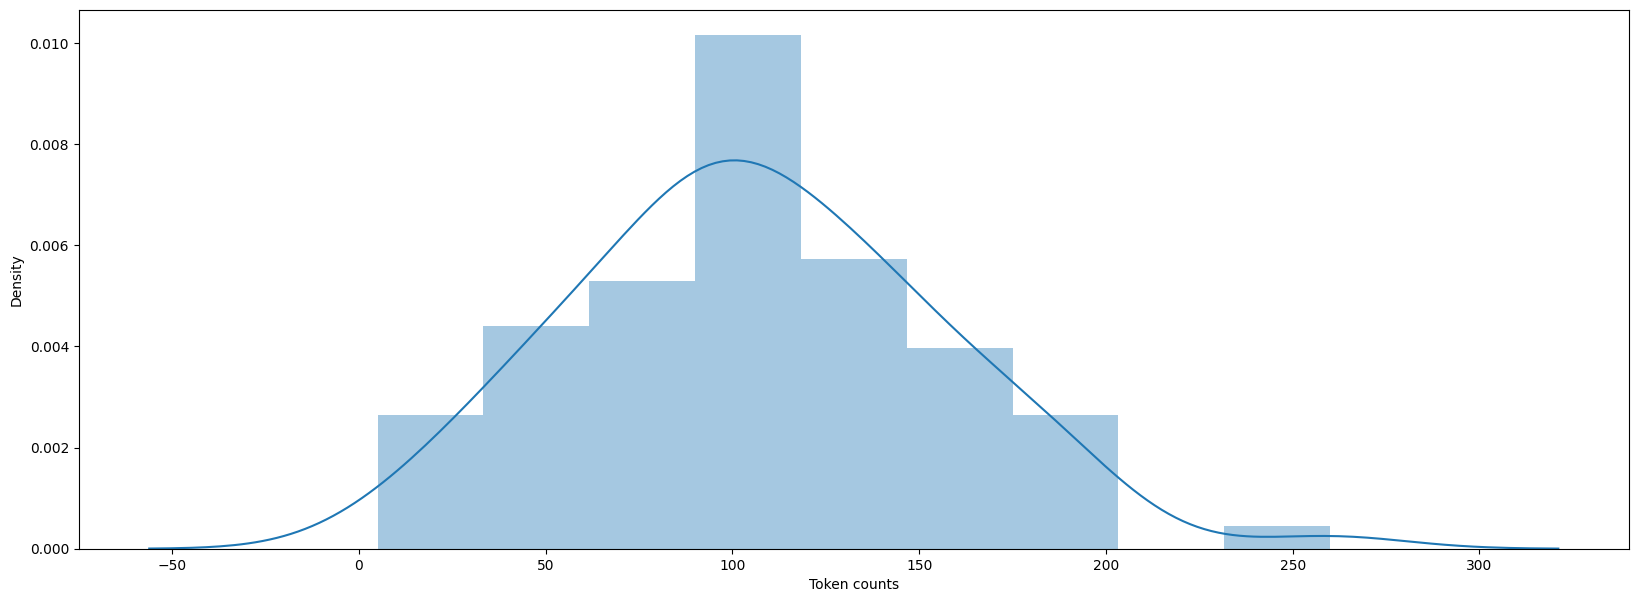

Max len: 260


In [ ]:
lenx = []
for txt in train_df['Combined Sentence']:
  encodes = tokenizer.encode_plus(txt) #we have already defined the tokenizer
  lenx.append(len(encodes['input_ids']))


#ploting the length distribution
plt.figure(figsize=(20,7))
sns.distplot(lenx)
plt.xlabel('Token counts')
plt.show()

print('Max len: {}'.format(np.max(lenx)))
MAX_LEN = np.max(lenx)+10

In [ ]:
#Preparing the text for BERT

def encode(texts, MAX_LEN):
  input_ids =[]
  attention_masks =[]
  token_type_ids =[]

  for text in tqdm(texts):
    tokens = tokenizer.encode_plus(text, max_length= MAX_LEN, padding='max_length', return_tensors='tf',truncation=True)
    input_ids.append(tokens['input_ids'][0])
    attention_masks.append(tokens['attention_mask'][0])
    token_type_ids.append(tokens['token_type_ids'][0])
    # print(tokens['input_ids'][0])


  return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids)

In [ ]:
#encoding

input_ids_train, attention_mask_train, token_type_ids_train =encode(train_df['Combined Sentence'],MAX_LEN)
input_ids_train.shape

  0%|          | 0/80 [00:00<?, ?it/s]

(80, 270)

In [ ]:
#Creating array of target variables

#y_real = np.array(df['realistic'])
y_inve = np.array(train_df['Investigative'])
y_arti = np.array(train_df['Artistic'])
y_soci = np.array(train_df['Social'])
y_ente = np.array(train_df['Enterprising'])
y_conv = np.array(train_df['Conventional'])

In [ ]:
#Model Building
def build_model(input_ids_train, attention_mask_train, token_type_ids_train):

    input_id = Input(shape =(MAX_LEN,),dtype =tf.int32)
    att_mask = Input(shape =(MAX_LEN,),dtype =tf.int32)
    token_type = Input(shape =(MAX_LEN,),dtype =tf.int32)

    embed = bert([input_id,att_mask,token_type])

    cls_output = embed[0][:,0,:] #embedding of the [CLS] token


    # realistic_out = Dropout(0.1)(cls_output)
    # realistic_out = Dense(1, activation= 'sigmoid')(realistic_out)

    investigative_out = Dropout(0.1)(cls_output)
    investigative_out = Dense(1, activation= 'sigmoid')(investigative_out)

    artistic_out = Dropout(0.1)(cls_output)
    artistic_out = Dense(1, activation= 'sigmoid')(artistic_out)

    social_out = Dropout(0.1)(cls_output)
    social_out = Dense(1, activation= 'sigmoid')(social_out)

    enterprising_out = Dropout(0.1)(cls_output)
    enterprising_out = Dense(1, activation= 'sigmoid')(enterprising_out)

    conventional_out = Dropout(0.1)(cls_output)
    conventional_out = Dense(1, activation= 'sigmoid')(conventional_out)

    model = Model(inputs=[input_id,att_mask,token_type], outputs = [investigative_out,artistic_out,social_out,enterprising_out,conventional_out])
    optimizer = Adam(learning_rate=0.001)

    model.compile(loss = 'binary_crossentropy',optimizer = optimizer,metrics=['accuracy'])

    return model

In [ ]:
#model building
bert_model = build_model(input_ids_train, attention_mask_train, token_type_ids_train)

#model training

bert_model.fit([input_ids_train,attention_mask_train,token_type_ids_train],[y_inve,y_arti,y_soci,y_ente,y_conv],
            batch_size=4,
            epochs=1,
            validation_split=0.2)

16/16 [==============================] - 266s 15s/step - loss: 4.4885 - dense_loss: 0.7583 - dense_1_loss: 0.3842 - dense_2_loss: 1.3530 - dense_3_loss: 1.0581 - dense_4_loss: 0.9349 - dense_accuracy: 0.6875 - dense_1_accuracy: 0.8594 - dense_2_accuracy: 0.5781 - dense_3_accuracy: 0.5781 - dense_4_accuracy: 0.5312 - val_loss: 2.9842 - val_dense_loss: 0.6294 - val_dense_1_loss: 0.0041 - val_dense_2_loss: 0.6223 - val_dense_3_loss: 0.8368 - val_dense_4_loss: 0.8917 - val_dense_accuracy: 0.6875 - val_dense_1_accuracy: 1.0000 - val_dense_2_accuracy: 0.6875 - val_dense_3_accuracy: 0.6250 - val_dense_4_accuracy: 0.6875


In [ ]:
# Assuming df_test is your test DataFrame
input_ids_test, attention_mask_test, token_type_ids_test = encode(test_df['Combined Sentence'][:10], MAX_LEN)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
predictions = bert_model.predict([input_ids_test, attention_mask_test, token_type_ids_test])

1/1 [==============================] - 13s 13s/step


In [ ]:
# Convert probabilities to class labels based on a threshold
class_labels = [np.where(pred > 0.5, 1, 0) for pred in predictions]

In [ ]:
# Assuming you have true labels similar to your training set
y_true_inve = np.array(test_df['Investigative'][:10])
y_true_arti = np.array(test_df['Artistic'][:10])
y_true_soci = np.array(test_df['Social'][:10])
y_true_ente = np.array(test_df['Enterprising'][:10])
y_true_conv = np.array(test_df['Conventional'][:10])

# Example: Calculate accuracy for the 'Investigative' category
from sklearn.metrics import accuracy_score
accuracy_inve = accuracy_score(y_true_inve, class_labels[0])
print(f"Accuracy for Investigative: {accuracy_inve}")

accuracy_art = accuracy_score(y_true_arti, class_labels[1])
print(f"Accuracy for Artistic: {accuracy_art}")

accuracy_socl = accuracy_score(y_true_soci, class_labels[2])
print(f"Accuracy for Social: {accuracy_socl}")

accuracy_entrp = accuracy_score(y_true_ente, class_labels[3])
print(f"Accuracy for Enterprising: {accuracy_entrp}")

accuracy_conv = accuracy_score(y_true_conv, class_labels[4])
print(f"Accuracy for Conventional: {accuracy_conv}")

Accuracy for Investigative: 0.6
Accuracy for Artistic: 1.0
Accuracy for Social: 0.7
Accuracy for Enterprising: 0.8
Accuracy for Conventional: 0.7
